# Quora Question Pairs

### Metrice(s):
- Log Loss.
- Binary Confusion Matrix.

## 2.3 Train and Test Construction

We build train and test by randomly splitting in the ration of <font color='red'><b>70:30</b></font> or <font color='red'><b>80:20</b></font> whatever we choose as we have sufficient points to work with.
**NOTE:** Time-based splittin would be efficient, but since we don't have the timestamp of the questions, we can't use it.

## 3. Exploratory Data Analysis

In [457]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from subprocess import check_output # New to the course
import plotly.offline as py # New to the Course
py.init_notebook_mode(connected=True) # New to the Course
import plotly.graph_objs as go # New to the Course
import plotly.tools as tls # New to the Course
import os
import gc # New to the course

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz

import warnings
warnings.filterwarnings('ignore')

In [425]:
%matplotlib inline
%precision 2
plt.style.use('ggplot')
sns.set_style('white')

In [426]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-question-pairs/sample_submission.csv
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/train.csv


## 3.1 Reading data and Basic Stats

In [427]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv')

print('Number of data points:', df.shape[0])

Number of data points: 404290


In [428]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
168830,168830,261414,261415,How do I download Inc.5000 2014 list?,How do I download Inc.5000 2015 list?,0
232797,232797,240315,342882,What does it mean when you dream of getting sh...,What does it mean to be shot in the back of th...,0
386829,386829,519081,519082,"Men of the Night's watch, who died between yea...",What are the best New Year's Eve shows to watc...,0
152324,152324,239330,239331,What is the fee structure for a 4-year B.Tech ...,How many seats are there for a B.Tech in KIIT ...,0
160593,160593,250414,250415,How is FanDuel legal?,How is FanDuel legal in the U.S.?,0


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Observation:
- we can see from `info`, that `question1` and `question2` columns have some null values, but it's not that much.

We are given a minimal number of data fields here, consisting of:
- id: Looks like a simple rowID.
- qid{1, 2}: The unique ID of each question in the pair.
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicated of each other.

## 3.2.1 Distribution of data points among output classes
Number of duplicate(similar) and non-duplicate(non-similar) questions.

In [430]:
def show_annotation(colName):
    # Add Anootations
    n_points = df.shape[0]
    duplicate_count = df[colName].value_counts()
    locs, labels = plt.xticks() # Get the current tick locations and labels

    # Loop for through each pair of locations and labels.
    for loc, label in zip(locs, labels):
        count = duplicate_count[int(label.get_text())]
        text  = '{:.2f}%'.format(100*count/n_points)
        plt.text(loc, count-50, text, ha='center', color='darkblue')  

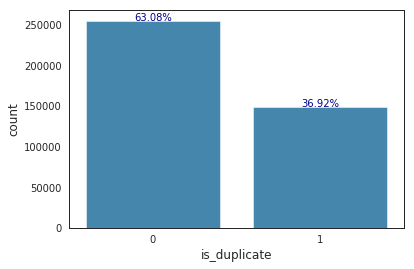

In [431]:
base_color = sns.color_palette()[1]
sns.countplot(data=df, x='is_duplicate', color=base_color);

show_annotation('is_duplicate')

In [432]:
def bg(value, color='blue'):
    return colored(' '+str(value)+' ', color, attrs=['reverse', 'blink'])

In [488]:
totalRows = df.shape[0]
print('~> Total number of question pairs for training:\t {:,}'.format(totalRows))

~> Total number of question pairs for training:	 404,290


In [434]:
numSimilarQuestions    = len(df[df['is_duplicate']==1])
numNotSimilarQuestions = len(df[df['is_duplicate']==0])

print('~> Percentage of Similar Questions (is_duplicate = 1): {:.2f}%'.format(((numSimilarQuestions/totalRows)*100)))
print('~> Percentage of Non-Similar Questions (is_duplicate = 0): {:.2f}%'.format(((numNotSimilarQuestions/totalRows)*100)))

~> Percentage of Similar Questions (is_duplicate = 1): 36.92%
~> Percentage of Non-Similar Questions (is_duplicate = 0): 63.08%


### 3.2.2 Number of unique questions

In [435]:
# Unique questions.
unique_questions = pd.Series(data=list(set(df['qid1']) | set(df['qid2'])))
n_unique_questions = unique_questions.count()
print('~> Number of Unique questions:', bg(n_unique_questions))

# Number of questions that appeared more than one.
qids = pd.Series(list(df['qid1']) + list(df['qid2']))
questions_appear_more_one = (qids.value_counts() > 1)
n_questions_appear_more_one = np.sum(questions_appear_more_one)
print('~> Number of unique questions that appear more than one time:', bg(n_questions_appear_more_one))

# Max number of times for a question that appeared.
max_n_times = max(qids.value_counts())
print('~> Max number of times a single questions is repeated:', bg(max_n_times))

~> Number of Unique questions:  537933 
~> Number of unique questions that appear more than one time:  111780 
~> Max number of times a single questions is repeated:  157 


## 3.2.3 Checking for Duplicates

In [437]:
# Checking whether there are any repeated pair of questions
n_pair_duplicates = df.duplicated().sum()
print('~> Number of duplicated pairs:', bg(n_pair_duplicates))

~> Number of duplicated pairs:  0 


## 3.2.4 Number of Occurrences of each question

The question that has been questioned the most is:  What are the best ways to lose weight? 


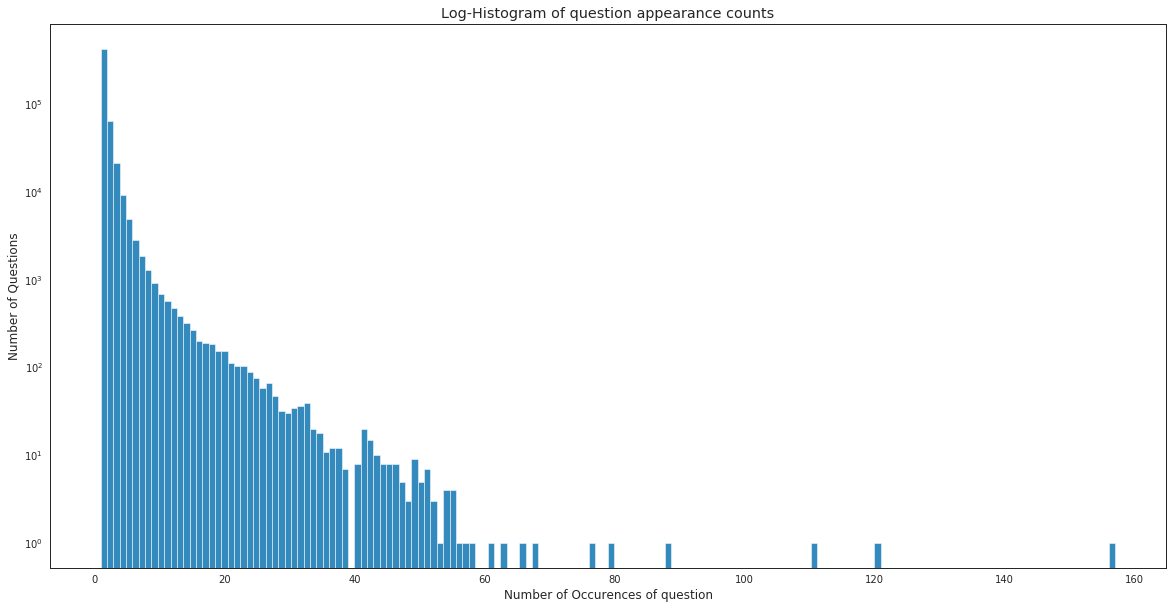

In [438]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160, color=base_color)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of Occurences of question')
plt.ylabel('Number of Questions');
print("The question that has been questioned the most is:", bg(df[df['qid1']==(2559)]['question1'].iloc[0]));

## 3.2.5 Checking for NULL values

In [439]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [440]:
# Checking Null values
print('~> Number of rows that contain (NaN) value:', bg(len(df[(df['question1'].isnull()) | (df['question2'].isnull())] )))
df[(df['question1'].isnull()) | (df['question2'].isnull())] 

~> Number of rows that contain (NaN) value:  3 


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [441]:
df.fillna('?', inplace=True)
print('~> Number of rows that contain (NaN) value:', bg(len(df[(df['question1'].isnull()) | (df['question2'].isnull())] )))
df[(df['question1'].isnull()) | (df['question2'].isnull())]

~> Number of rows that contain (NaN) value:  0 


,id,qid1,qid2,question1,question2,is_duplicate


## 3.3 Basic Feature Extraction (Before Cleaning)
Let us construct a few features like:
- **freq_qid1**: Frequency of qid1's.
- **freq_qid2**: Frequency of qid2's.
- **q1len**: Length of q1.
- **q2len**: Length of q2.
- **q1_n_words**: Number of words in Question 1.
- **q2_n_words**: Number of words in Question 2.
- **word_common**: (Number of common words in question 1 and question 2).
- **word_total**: (Total number of words in question 1 + total number of words in question 2).
- **word_share**: (word_common)/(word_total).
- **freq_q1+freq_q2**: Sum total of frequency of qid1 and qid2.
- f**req_q1-freq_q2**: Absolute difference of frequency of qid1 and qid2.

In [442]:
def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [443]:
%%time
df['freq_qid1']   = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']   = df.groupby('qid2')['qid2'].transform('count')
df['q1len']       = df['question1'].apply(len)
df['q2len']       = df['question2'].apply(len)
df['q1_n_words']  = df['question1'].map(lambda x: len(x.split()))
df['q2_n_words']  = df['question2'].map(lambda x: len(x.split()))
df['word_common'] = df.apply(normalized_word_Common, axis=1)
df['word_total']  = df.apply(normalized_word_Total, axis=1)
df['word_share']  = df.apply(normalized_word_share, axis=1)
df['freq_q1+q2']  = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2']  = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv('df_fe_without_preprocessing_train.csv', index=False)

CPU times: user 50.4 s, sys: 660 ms, total: 51.1 s
Wall time: 51.1 s


In [444]:
%%time
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    df['freq_qid1']   = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']   = df.groupby('qid2')['qid2'].transform('count')
    df['q1len']       = df['question1'].apply(len)
    df['q2len']       = df['question2'].apply(len)
    df['q1_n_words']  = df['question1'].map(lambda x: len(x.split()))
    df['q2_n_words']  = df['question2'].map(lambda x: len(x.split()))
    df['word_common'] = df.apply(normalized_word_Common, axis=1)
    df['word_total']  = df.apply(normalized_word_Total, axis=1)
    df['word_share']  = df.apply(normalized_word_share, axis=1)
    df['freq_q1+q2']  = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2']  = abs(df['freq_qid1']-df['freq_qid2'])
    
    df.to_csv('df_fe_without_preprocessing_train.csv', index=False)
df.sample(5)

CPU times: user 1.11 s, sys: 200 ms, total: 1.31 s
Wall time: 1.31 s


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
236736,236736,347726,347727,Economic order quantity?,Good engineering colleges after 12 and their e...,0,1,1,24,66,3,9,0.0,12.0,0.000000,2,0
362698,362698,122997,18273,Where can I get great range of flavours for cu...,Where can I found different flavours for cupca...,1,8,9,67,64,13,11,9.0,24.0,0.375000,17,1
374706,374706,17812,4407,Why do so many people on Quora ask stupid ques...,Why do people on Quora ask silly questions abo...,1,14,24,133,92,26,17,7.0,41.0,0.170732,38,10
254610,254610,369360,369361,Which virtual card will support in scribd logi...,What is a good name for an invention?,0,1,1,79,37,14,8,0.0,20.0,0.000000,2,0
255621,255621,370543,84589,If a woman gets pregnant and the man wants to ...,If a woman chooses to keep a pregnancy when he...,1,2,4,122,131,25,25,11.0,46.0,0.239130,6,2


## 3.3.1 Analysis of some of the Extracted Features:
Here are some questions have only one single words.

In [445]:
print('~> Minimum length of a question in question1:', bg(min(df['q1_n_words'])))
print('~> Minimum length of a question in question2:', bg(min(df['q2_n_words'])))
print('~> Number of questions with minimum number of words [question1]:', bg(df[df['q1_n_words']==min(df['q1_n_words'])].shape[0]))
print('~> Number of questions with minimum number of words [question2]:', bg(df[df['q2_n_words']==min(df['q2_n_words'])].shape[0]))

~> Minimum length of a question in question1:  1 
~> Minimum length of a question in question2:  1 
~> Number of questions with minimum number of words [question1]:  70 
~> Number of questions with minimum number of words [question2]:  27 


### 3.3.1.1 Feature: Word Share

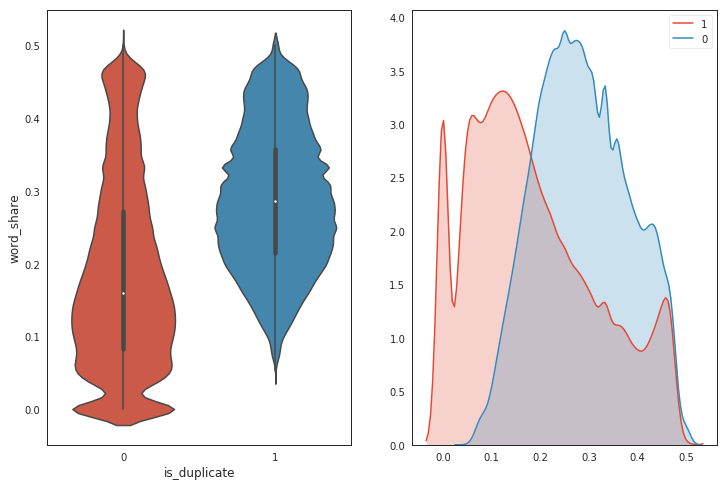

In [447]:
plt.figure(figsize=(12, 8))

plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_share', data=df)

plt.subplot(122)
sns.kdeplot(df[df['is_duplicate']==0]['word_share'], label='1', shade=True)
sns.kdeplot(df[df['is_duplicate']==1]['word_share'], label='0', shade=True);

**Observation:**
- The distributions for normalized word share have some overlap on the far right-hand side, i.e. there are quite a lot of questions with high word similarity.

### 3.3.1.2 Feature: word_common:

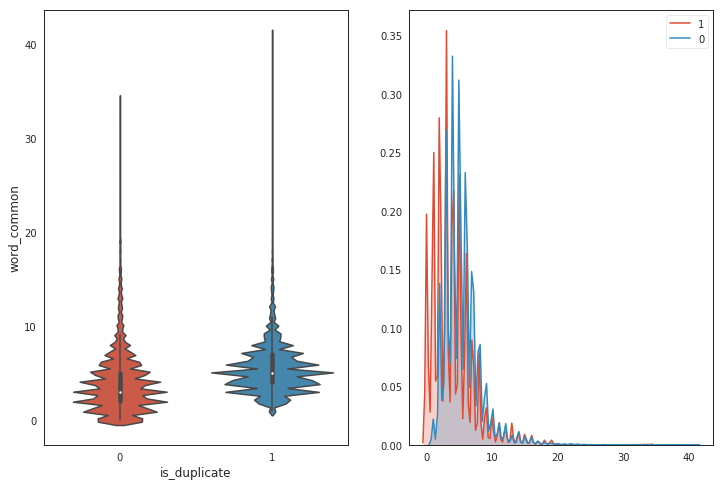

In [448]:
plt.figure(figsize=(12, 8))

plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_common', data=df)

plt.subplot(122)
sns.kdeplot(df[df['is_duplicate']==0]['word_common'], label='1', shade=True)
sns.kdeplot(df[df['is_duplicate']==1]['word_common'], label='0', shade=True);

**Observation:**
<br>
The distributions of the `word_common` feature in similar and non-similar questions are highly overlapping.

## 1.2.1: EDA: Advanced Feature Extraction:
### 3.4: Preprocessing of Text:
- Remove html tags.
- Remove Punctuations.
- Perform Stemming.
- Remove Stopwords.
- Expande contractions etc.

In [451]:
# To get the results in 4 decemal points
SAFE_DIV= .0001
STOPWORDS = stopwords.words('english')

def preprocess(x):
    x = str(x).lower()
    x = x.replace(',000,000', 'm').replace(',000', 'k').replace('won\'t', 'will not')\
         .replace('cannot', 'can not').replace('can\'t', 'can not').replace('n\'t', 'not')\
         .replace("what's", 'what is').replace("it's", 'it is').replace("'ve", 'have')\
         .replace("i'm", 'i am').replace("'re", 'are').replace("he's", 'he is')\
         .replace("she's", 'she is').replace("$", 'dollar').replace("'s", " own")\
         .replace("%", " percent ").replace("₹", " rupee ")\
         .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)
**Definition**:
- Token: You get a token by splitting sentence a space
- Stop_Word : stop words as per NLTK.
- Word : A token that is not a stop_word

**Features**:
- cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
- cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 

- cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
- cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 

- csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
- csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

- csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
- csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

- ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
- ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


- ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
- ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


- last_word_eq : Check if First word of both questions is equal or not
- last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 


- first_word_eq : Check if First word of both questions is equal or not
- first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 


- abs_len_diff : Abs. length difference
- abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 


- mean_len : Average Token Length of both Questions
- mean_len = (len(q1_tokens) + len(q2_tokens))/2 


fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [465]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in questions.
    q1_words = set([word for word in q1_tokens if word not in STOPWORDS])
    q2_words = set([word for word in q2_tokens if word not in STOPWORDS])
    
    # Get the stopwords in questions
    q1_stops = set([word for word in q1_tokens if word in STOPWORDS])
    q2_stops = set([word for word in q2_tokens if word in STOPWORDS])
    
    # Get the common words (non-stopwords) from question pair.
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the number of common stopwords from quesiton pair.
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get teh common tokens from question pair.
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] =  common_word_count / (min(len(q1_words), len(q1_words)) + SAFE_DIV)
    token_features[1] =  common_word_count / (max(len(q1_words), len(q1_words)) + SAFE_DIV)
    token_features[2] =  common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] =  common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not.
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not.
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # Get absolute lenthg difference.
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average length of both questions.
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

In [466]:
from array import array


def lcsubstrings(seq1, seq2, positions=False):
	"""Find the longest common substring(s) in the sequences `seq1` and `seq2`.
	
	If positions evaluates to `True` only their positions will be returned,
	together with their length, in a tuple:
	
		(length, [(start pos in seq1, start pos in seq2)..])
	
	Otherwise, the substrings themselves will be returned, in a set.
	
	Example:
	
		>>> lcsubstrings("sedentar", "dentist")
		{'dent'}
		>>> lcsubstrings("sedentar", "dentist", positions=True)
		(4, [(2, 0)])
	"""
	L1, L2 = len(seq1), len(seq2)
	ms = []
	mlen = last = 0
	if L1 < L2:
		seq1, seq2 = seq2, seq1
		L1, L2 = L2, L1
	
	column = array('L', range(L2))
	
	for i in range(L1):
		for j in range(L2):
			old = column[j]
			if seq1[i] == seq2[j]:
				if i == 0 or j == 0:
					column[j] = 1
				else:
					column[j] = last + 1
				if column[j] > mlen:
					mlen = column[j]
					ms = [(i, j)]
				elif column[j] == mlen:
					ms.append((i, j))
			else:
				column[j] = 0
			last = old
	
	if positions:
		return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
	return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)


In [470]:
def get_longest_substr_ratio(a, b):
    strs = list(lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [473]:
def extract_features(df):
    # Preprocessing each question.
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    
    # Merging Features with dataset.
    print(bg('Token Features...', 'green'))
    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    # Computing Fuzzy Features and merging with dataset.
    print(bg('Fuzzy Features...', 'green'))
    df['token_set_ratio']      = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio']     = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
    df['fuzz_ratio']           = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio']   = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)
    
    return df

In [475]:
%%time
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
    df.fillna('', inplace=True)
else:
    print(bg('Extracting Features for Train:', 'green'))
    df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv')
    df = extract_features(df)
    df.to_csv('nlp_features_train.csv', index=False)
df.sample(3)

 Extracting Features for Train: 
 Token Features... 
 Fuzzy Features... 
CPU times: user 13min 6s, sys: 4.13 s, total: 13min 10s
Wall time: 13min 10s


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
307317,307317,382680,365050,is it possible to cheer up a depressed person,is it possible to cheer up someone who is clin...,1,0.749981,0.749981,0.799984,0.799984,...,0.636358,0.0,1.0,2.0,10.0,89,67,71,70,0.574468
390147,390147,522647,289477,what is the best social media management tool,what are some social media management tools,1,0.599988,0.599988,0.333322,0.333322,...,0.499994,0.0,1.0,1.0,7.5,86,84,84,82,0.644444
190582,190582,174592,2718,what is the best decision you ever made,what has been the best decision youhave made i...,1,0.999967,0.999967,0.399992,0.333328,...,0.454541,0.0,1.0,3.0,9.5,82,71,73,82,0.536585


## 3.5.1: Analysis of Extracted Features:
### 3.5.1.1: Plotting Word Clouds:
- Creating Word Cloud of Dulicates and Non-Duplicates question pairs.
- We can observe the most frequent occuring words.

In [487]:
df_duplicate    = df[df['is_duplicate']==1]
df_nonduplicate = df[df['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

print('Number of datapoints in class 1 (Duplicate Pairs): {:,}'.format(len(p)))
print('Number of datapoints in class 0 (Non Duplicate Pairs): {:,}'.format(len(n)))

# Saving the np.array into a text file.
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of datapoints in class 1 (Duplicate Pairs): 298,526
Number of datapoints in class 0 (Non Duplicate Pairs): 510,054
